In [1]:
import torch
import torch.nn as nn

import traci
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import math


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Recreate the same model architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, batch_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, batch_size)
        # self.fc2 = nn.Linear(batch_size, batch_size)
        self.fc3 = nn.Linear(batch_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Define state and action space sizes
state_space_size = 4  # Replace with your value
action_space_size = 2  # Replace with your value
BATCH_SIZE = 32


# # Initialize the policy network
model = DQN(state_space_size, action_space_size, BATCH_SIZE)

# # Load the trained weights
# model.load_state_dict(torch.load("model.pth"))

# # Set the model to evaluation mode
# model.eval()


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "dqn_model.pth"  # Path to your saved model

# Load Model
model = torch.load(model_path, map_location=DEVICE)
model.eval()  # Set the model to evaluation mode if you're using it for inference

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [5]:
# SUMO setup
SUMO_BINARY = "sumo-gui"  # or "sumo" for non-GUI mode
SUMO_CONFIG = "../config/my_simulation.sumocfg"  # Path to your SUMO config file

# Simulation parameters
STEPS_PER_EPISODE = 10000  # Number of steps to simulate

In [6]:
def get_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

def get_nearest_vehicle_distance(junction_id, edge_id):
    """
    Get the smallest distance between a junction and the nearest vehicle on a specific edge.
    
    Args:
    - junction_id: ID of the junction (e.g., "J11").
    - edge_id: ID of the edge (e.g., "E6").
    
    Returns:
    - Smallest distance to the nearest vehicle or None if no vehicles are on the edge.
    """
    # Get the position of the junction
    junction_position = traci.junction.getPosition(junction_id)
    
    # Get the list of vehicle IDs on the specified edge
    vehicle_ids = traci.edge.getLastStepVehicleIDs(edge_id)
    
    if not vehicle_ids:
        # No vehicles on the edge
        return float('inf')
    
    # Calculate distances from the junction to each vehicle
    distances = []
    for vehicle_id in vehicle_ids:
        vehicle_position = traci.vehicle.getPosition(vehicle_id)
        distance = get_distance(junction_position, vehicle_position)
        distances.append(distance)
    
    # Return the smallest distance
    return min(distances)

In [7]:
def get_state():
    """Retrieve the current state from SUMO."""

    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")   #sum(traci.lane.getLastStepVehicleNumber(lane) for lane in ["E6_0", "E6_1", "E6_2"])
    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    junction_density = traci.edge.getLastStepVehicleNumber(":J11_2")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")   #sum(traci.lane.getLastStepMeanSpeed(lane) for lane in ["E6_0", "E6_1", "E6_2"]) / 3
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    # highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7"))
    # if highway_density > 0 and traci.edge.getLastStepVehicleNumber("E7") > 0:       
    #     highway_speed /= 2                                      # Mean

    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Collisions
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()

    # Emergency stopping cars
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")
    

    #######################################################
    state = [
        # highway_halts,
        # ramp_halts,
        highway_speed,
        ramp_speed,
        
        highway_density,
        # ramp_density,

        nearest_distance_highway
    ]
    #######################################################
    
    return state


def calculate_reward(state):
    """Calculate reward based on the current state."""

    #######################################################
    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")   #sum(traci.lane.getLastStepVehicleNumber(lane) for lane in ["E6_0", "E6_1", "E6_2"])
    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    junction_density = traci.edge.getLastStepVehicleNumber(":J11_2")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")   #sum(traci.lane.getLastStepMeanSpeed(lane) for lane in ["E6_0", "E6_1", "E6_2"]) / 3
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    # highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7"))
    # if highway_density > 0 and traci.edge.getLastStepVehicleNumber("E7") > 0:       
    #     highway_speed /= 2                                      # Mean

    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Collisions
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()

    # Emergency stopping cars
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")


    #######################################################
    # highway_density, ramp_density, highway_speed, ramp_speed = state
    # highway_halts = state[0]
    # ramp_halts = state[1]
    # highway_speed = state[2]
    # ramp_speed = state[3]
    # highway_density = state[4]
    # ramp_density = state[5]

    # reward = - (highway_halts + ramp_halts) + (highway_speed + ramp_speed)
    reward = - (highway_halts + ramp_halts + ramp_density) + (highway_speed + ramp_speed) * 0.1 - nbr_colliding_vehicles * 10

    #######################################################

    ## Get the current traffic light state
    # light_state = traci.trafficlight.getRedYellowGreenState("J11")
    # if "r" in light_state:  # The ramp phase is red             # Check if the phase is red for ramp traffic
    #     reward -= 0.02  # Small penalty for a red light phase (adjust the penalty value as needed)
    
    return reward



In [8]:
def choose_action(state):
    """Choose action using the trained policy network."""
    state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    with torch.no_grad():  # No gradient computation for inference
        action = model(state_tensor).argmax(dim=1).item()  # Get the best action
    return action


def take_action(action):
    """Apply the selected action in SUMO."""
    traci.trafficlight.setPhase("J11", action)

update_plot_frequency = 10

def run_inference():
    """Run SUMO simulation with the trained DQN model."""
    traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
    
    
    total_reward = 0
    state = get_state()  # Get the current state
    rewards_per_step = []  # List to store rewards for plotting
    steps = []  # List to store step indices for plotting

    # Initialize the plot (Ensure only one figure is created)
    plt.ion()  # Enable interactive mode
    fig, ax = plt.subplots(figsize=(8, 6))  # Create the plot
    ax.set_title("Reward per Step")
    ax.set_xlabel("Step")
    ax.set_ylabel("Reward")
    line, = ax.plot([], [], label="Total Reward", color='blue')  # Initialize line plot
    ax.legend()


    for step in range(STEPS_PER_EPISODE):
        # state = get_state()  # Get the current state
        action = choose_action(state)  # Get action from the trained model
        take_action(action)  # Execute the action in SUMO





        next_state = get_state()
        reward = calculate_reward(next_state)
        # total_reward += reward
        rewards_per_step.append(reward)  # Append the cumulative reward
        steps.append(step)

        # Update the plot at the specified frequency
        if step % update_plot_frequency == 0 or step == STEPS_PER_EPISODE - 1:
            line.set_data(steps, rewards_per_step)  # Update the line data
            ax.relim()  # Recalculate limits based on new data
            ax.autoscale_view()  # Autoscale the view to fit new data
            plt.draw()  # Redraw the plot
            plt.pause(0.01)  # Pause briefly to render updates

            clear_output(wait=True)
            display(fig)

        state = next_state




        traci.simulationStep()  # Advance the simulation by one step
    
    traci.close()
    plt.ioff()  # Disable interactive mode
    plt.show()  # Display the final plot


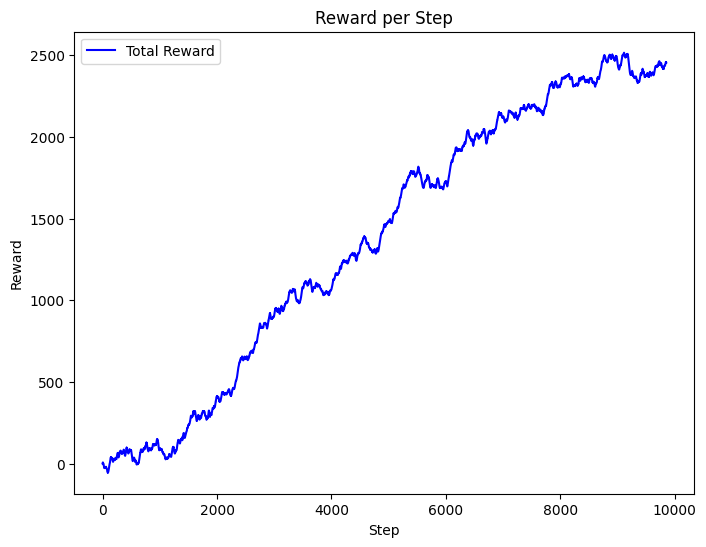

<Figure size 640x480 with 0 Axes>

In [ ]:
# Run the inference
run_inference()